In [2]:
import os
import cv2
import laspy as lp
import numpy as np
import pyvista as pv 
import matplotlib.pyplot as plt

from PIL import Image
from scipy.interpolate import griddata

ModuleNotFoundError: No module named 'cv2'

In [3]:
def read_las_file(las_path: str):
    try:
        return lp.read(las_path)
    except Exception as e:
        print(f"Error reading {las_path}: {e}")
        return None

def normalize_points(points, eps= 1e-8):
    if not isinstance(points, np.ndarray) or points.shape[1] != 3:
        raise ValueError("points must be a numpy array with shape (n, 3).")
    points_ = points.copy()

    x_min, x_max = np.min(points_[:,0]), np.max(points_[:,0])
    y_min, y_max = np.min(points_[:,1]), np.max(points_[:,1])
    z_min, z_max = np.min(points_[:,2]), np.max(points_[:,2])

    points_[:,0] = (points_[:,0] - x_min) / (x_max - x_min + eps)
    points_[:,1] = (points_[:,1] - y_min) / (y_max - y_min + eps)
    points_[:,2] = (points_[:,2] - z_min) / (z_max - z_min + eps)
    
    return points_, x_min, x_max, y_min, y_max, z_min, z_max  
   
def normalize_colors(colors):
    rgba = colors - colors.min(axis=0)
    rgba = rgba / rgba.max(axis=0)
    return rgba #(rgba * 255).astype(np.uint8)

def get_points_and_colors_from_las(las_path: str, limit: int = -1):
    if not isinstance(las_path, str):
        raise ValueError("las_path must be a string.")
    if not isinstance(limit, int) or limit < -1:
        raise ValueError("limit must be an integer greater than or equal to -1.")

    las = read_las_file(las_path)
    if las is None:
        raise ValueError("No valid LAS file found.")

    points = np.vstack((las.x, las.y, las.z)).transpose()
    colors = np.vstack((las.red, las.green, las.blue)).transpose()

    if limit > 0:
        idxs = np.random.choice(len(points), limit, replace=False)
        points = points[idxs]
        colors = colors[idxs]

    rgba_colors = normalize_colors(colors)
    return points, colors, rgba_colors, np.expand_dims(las.classification, -1)

In [ ]:
POOL_NAME = 'RBS'
PROJECT_NAME = '250111_Pools_100kHz_120m'
PATH_PROJECT_LAS = f'data/{PROJECT_NAME}/{POOL_NAME}_clasificada_col_0_row_0_19s.las'
OUTPUTS_PATH = f'outputs/{PROJECT_NAME}/{POOL_NAME}'
LIMIT = -1

if not os.path.exists(OUTPUTS_PATH):
    os.makedirs(OUTPUTS_PATH)

In [ ]:
las_points, las_colors, las_rgba_colors, las_clasification = get_points_and_colors_from_las(PATH_PROJECT_LAS, limit=LIMIT)
las_points_norm, x_min, x_max, y_min, y_max, z_min, z_max = normalize_points(las_points[:,:3])

las_data_points = np.hstack((las_points_norm, las_rgba_colors, las_clasification))

other_points = las_data_points[las_data_points[:,-1] != 65]
water_points = las_data_points[las_data_points[:,-1] == 65]

mean_of_water_points = np.mean(water_points[:,2], axis=0)
percentile_99 = np.percentile(water_points[:,2], 99)

delta = 0.05
X = other_points[:, 0]
Y = other_points[:, 1]
Z = other_points[:, 2]

distances = Z - mean_of_water_points

# # Crear un plotter de PyVista
plotter = pv.Plotter()

# Separar los puntos por encima y por debajo del plano
below_plane = distances < -delta
above_plane = distances >= delta

water_points_pv = pv.PolyData(water_points[:,:3])
# plotter.add_points(water_points_pv, color='yellow', point_size=5)

# Añadir los puntos por debajo del plano en verde
points_below = np.column_stack((X[below_plane], Y[below_plane], Z[below_plane]))
points_below_pv = pv.PolyData(points_below)
plotter.add_points(points_below_pv, color='green', point_size=5)

# Añadir los puntos por encima del plano en rojo
# points_above = np.column_stack((X[above_plane], Y[above_plane], Z[above_plane]))
# points_above_pv = pv.PolyData(points_above)
# plotter.add_points(points_above_pv, color='red', point_size=5)

# Añadir el plano
plane = pv.Plane(center=[0.5, 0.5, mean_of_water_points], direction=[0, 0, 1], i_size=1, j_size=1)
plotter.add_mesh(plane, color='blue')

# Mostrar el plotter
plotter.show()

(1056926,) (1056926,)


Widget(value='<iframe src="http://localhost:40413/index.html?ui=P_0x7337c1342a80_1&reconnect=auto" class="pyvi…

In [ ]:
points_below = np.column_stack((X[below_plane], Y[below_plane], Z[below_plane]))

# Calcular las diagonales principales y secundarias
x_min_below = np.min(points_below[:, 0])
x_max_below = np.max(points_below[:, 0])
y_min_below = np.min(points_below[:, 1])
y_max_below = np.max(points_below[:, 1])

# Diagonal principal (de (x_min, y_min) a (x_max, y_max))
diagonal1 = np.array([x_min_below, y_min_below, 0]), np.array([x_max_below, y_max_below, 0])

# Diagonal secundaria (de (x_min, y_max) a (x_max, y_min))
diagonal2 = np.array([x_min_below, y_max_below, 0]), np.array([x_max_below, y_min_below, 0])

# Función para calcular la distancia de un punto a una línea
def distance_to_line(points, line_start, line_end):
    x0, y0, z0 = points[:, 0], points[:, 1], points[:, 2]
    x1, y1, z1 = line_start
    x2, y2, z2 = line_end
    numerator = np.abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
    denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    return numerator / denominator

# Umbral de distancia para considerar que un punto está en la diagonal
threshold = 0.0005

# Identificar los puntos que pertenecen a las diagonales
distances_diagonal1 = distance_to_line(points_below, diagonal1[0], diagonal1[1])
distances_diagonal2 = distance_to_line(points_below, diagonal2[0], diagonal2[1])

points_on_diagonal1 = points_below[distances_diagonal1 < threshold]
points_on_diagonal2 = points_below[distances_diagonal2 < threshold]

# Crear un plotter de PyVista
plotter = pv.Plotter()

# Añadir los puntos por debajo del plano en verde
points_below_pv = pv.PolyData(points_below)
plotter.add_points(points_below_pv, color='green', point_size=5)

# Añadir los puntos en las diagonales en azul
points_on_diagonal1_pv = pv.PolyData(points_on_diagonal1)
points_on_diagonal2_pv = pv.PolyData(points_on_diagonal2)
plotter.add_points(points_on_diagonal1_pv, color='blue', point_size=10)
plotter.add_points(points_on_diagonal2_pv, color='red', point_size=10)

# Mostrar el plotter
plotter.show()

In [ ]:
height_water = np.percentile(water_points[:,2], 99)
z_below = points_below[:,2] 
z = (height_water - z_below) * (z_max - z_min)

z_d1 = (height_water - points_on_diagonal1[:,2]) * (z_max - z_min) * -1
z_d2 = (height_water - points_on_diagonal2[:,2]) * (z_max - z_min) * -1
z_d2 = z_d2[::-1]

mean_diagonal1 = np.mean(z_d1)
mean_diagonal2 = np.mean(z_d2)
print(mean_diagonal1, mean_diagonal2)
print(np.mean(z))

plt.figure(figsize=(20, 6))
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(mean_diagonal1, color='blue', linestyle='--', linewidth=1)
plt.axhline(mean_diagonal2, color='red', linestyle='--', linewidth=1)
plt.plot(z_d1, label='Diagonal 1')
plt.plot(z_d2, label='Diagonal 2')
plt.xlabel('X Coordinate')
plt.ylabel('Height Difference (m)')
plt.title('Height Differences Along Diagonals')
plt.legend()
plt.show()

In [ ]:
import json

file = {
    "height_water": height_water,
    "denormalize" : {
        "x_min": x_min,
        "x_max": x_max,
        "y_min": y_min,
        "y_max": y_max,
        "z_min": z_min,
        "z_max": z_max
    },
    "diagonal1" : {
        "height": z_d1.tolist(),
        "mean": mean_diagonal1
    },
    "diagonal2" : {
        "height": z_d2.tolist(),
        "mean": mean_diagonal2
    }
}

with open(f'{OUTPUTS_PATH}/{POOL_NAME}.json', 'w') as json_file:
    json.dump(file, json_file, indent=4)

Grid Resolution: 2024 x 5065
Mean Height Difference (All REAL Points): 0.28 m


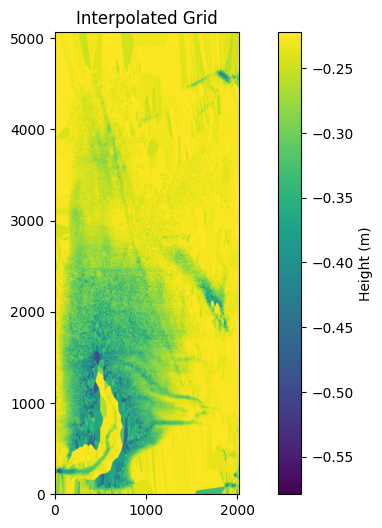

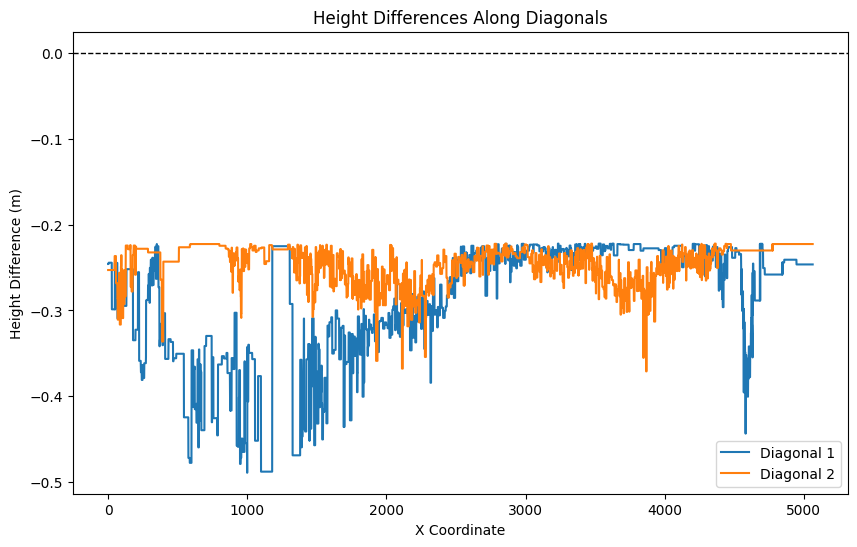

In [ ]:
p99 = np.percentile(water_points[:,2], 99)
z_below = points_below[:,2] 
z = (p99 - z_below) * (z_max - z_min)

h1 = points_below_pv
h0 = water_points_pv

# Assume h0 and h1 are both PyVista point clouds
x0, y0, z0 = h0.points[:, 0], h0.points[:, 1], h0.points[:, 2]
x1, y1, z1 = h1.points[:, 0], h1.points[:, 1], h1.points[:, 2]

# Step 5: Interpolate onto a regular grid for DEM visualization
grid_res_x = 2024 # Adjust resolution
x1_min, x1_max = x1.min(), x1.max()
y1_min, y1_max = y1.min(), y1.max()
grid_res_y = int(grid_res_x * (y_max - y_min) / (x_max - x_min))
print(f"Grid Resolution: {grid_res_x} x {grid_res_y}")

grid_x, grid_y = np.meshgrid(
    np.linspace(x1_min, x1_max, grid_res_x),
    np.linspace(y1_min, y1_max, grid_res_y)
)

grid_z = griddata((x1, y1), z, (grid_x, grid_y), method="nearest")*-1

plt.figure(figsize=(10, 6))
plt.imshow(grid_z, origin='lower', cmap='viridis')
plt.colorbar(label='Height (m)')
plt.title('Interpolated Grid')
plt.show()

In [ ]:
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"

z_save = grid_z.astype(np.float32) 
cv2.imwrite(f'{OUTPUTS_PATH}/{POOL_NAME}.exr', z_save)

pil_image_z = Image.fromarray(z_save)
pil_image_z.save(f'{OUTPUTS_PATH}/{POOL_NAME}.tiff')